# Stock Trades by Members of the US House of Representatives

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. The project describes itself as follows:

> With recent and ongoing investigations of incumbent congressional members being investigated for potentially violating the STOCK act. This website compiles this publicly available information in a format that is easier to digest then the original PDF source.
>
> Members of Congress must report periodic reports of their asset transactions. This website is purely for an informative purpose and aid in transparency.
>
> This site does not manipluate or censor any of the information from the original source. All data is transcribed by our community of contributors, which you can join for free by going to our transcription tool. Our moderation team takes great care in ensuring the accuracy of the information.
>
> This site is built and maintained by Timothy Carambat and supported with our contributors.

### Getting the Data

The full data set of stock trade disclosures is available as a CSV or as JSON at https://housestockwatcher.com/api.

This data set does not, however, contain the political affiliation of the congresspeople. \

# Summary of Findings

## Question:

Is there a statistically significant difference in the monetary amount of each investment on Big Tech companies between Members of Congress of different political parties?

### Introduction

The dataset we'll be working with is dataset containing transaction details of investments made by several Members of Congress. From my understanding, this data is self-reported by each MOC, and doesn't contain EVERY investment made by these MOC. In terms of the data itself, there are several columns which I'll sumarize in my own words below:
- disclosure year: the year in which the data was reported
- disclosure date: the date in which the data was reported
- transaction date: the date in which said transaction occured
- owner: the type of ownership of said transaction (joint, self, etc.)
- ticker: ticker or short hand code for the stock of said transaction
- asset description: description of said transaction
- type: the type of transaction (purchase or sell?)
- amount: monetary value of said transaction
- representative: name of the MOC who performed said transaction
- district: district of said MOC represents
- ptr_link: pointer record the transaction (sort of like a reciept)
- cap_gains_over_200_usd: was the capital gain of said transaction over 200 usd (True of False)

From the data set, we notice that we could use the amount column to answer our question. And we'll be aggregating the data by the party of the representative for each transaction (though we don't have a party column just yet but we address that below:)

### Cleaning and EDA

For this section we'll split up our thought process and findings in two sections: Cleaning and EDA.

##### Cleaning

Note that since we don't have the party of each representative, we had to load in two datasets we found from kaggle which we do below in the appropriate section. 

We then took the following steps to clean and prepare are data (roughly in the same order in which we cleaned the date below)
- First we removed any extra titles found in the representative name over all data sets to make the format of the name consistent
- After the naming was consistent over all dataframes, we merged the dataframes together (performing a left merge to keep all the transactions)
- Then, we fixed the missigness representation within each column (fixing '--' to NaN for example)
- Also, since the format of the parties between the two kaggle dataframes was different, we created a final_party column that had a consistent party denotation
- Finally, we fixed the amount column to make a more uniform format (before the amount column was a bucnh of random ranges of values, we simply made it a singular value by taking the midpoint of each range).

Most of the data cleaning process didn't really affect our question at hand. *The main thing that affected our experiement was the fact that amounts was a range and so by setting it to the midpoint of each bin we are effectively eliminating a lot of variation and randomness that may potentially affect the results of our experiment

##### EDA

In terms of EDA, we collected a few observations about the dataset, some perhaps more interesting than others

- The average amount spent on each transaction was around 41k*, with the smallest transaction being under 1k and the largest one over 50 million!
- The distribution of the amount spent on each transaction was skewed right, which was more or less expected
- Democrats had more total transactions for our dataset (9741 vs 5608), although there were more unique Republican investors for our data set (80 Republicans compared to 73 Democrats). In terms of party make-up, we have roughly a 50-50 split, although it is surprising that Democrats have made more investments than Republicans.
- A direct result form the one above is that Democrats makde way more transactions for our data set 133.43 transactions on average per Democrat while only 70.1 average transactions per Republican, nearly half!
- Republicans also spent more per investment (approximately 50k compared to 36k for Democrats)

### Assessment of Missingness

For the missigness, we analyzed the missigness of ticker. Below, we outline our steps and our findings.

We compared ticker against our two columns of interest: amount and party. Essentially, we looked at the distribution each column (amount and party) and comapred the distribution of those columns when ticker was missing and not missing. We then used TVD to calculate an observed metric in which we could then perform a permuation test and calculate a p-value to see if the dependency of ticker depended on those columns. We used a TVD because party was a categorical variable and while amount isn't exactly categorical, the date gave us pre determined bins in which we could easily plot a distribution in which we can see in the EDA section. Thus it made sense for use to run a TVD as our test statistic. We ran a permutation test by default since we were testing for missigness.

We found that missigness of ticker was dependent upon the amount invested (we got a p-value of 0) while not being dependent upon the party (we got a p-value of 0.15). A possible reason we came up for was that the ticker would more likely be purposely omitted if the amount was higher (since it would probably be a high profile investment), while the missigness of ticker was not dependent on party since one's political affiliation would not typically interfere with financial decisions (from an objective standpoint).

The result of this missigness might impact our experiment, since we're trying to get technology tickers, which might introduce us to some unwanted bias in the amount. However, since our question mainly focuses on the relationship of amount and party, we reasoned that the missigness of ticker won't impact that result TOO much. 

### Hypothesis Test

Again, the question we chose to answer was "Is there a statistically significant difference in the monetary amount of each investment on Big Tech companies between Members of Congress of different political parties?". Here are the steps we took to investigate this, as well as the results.

Null Hypothesis: There is no difference in the distribution of amount spent per transaction between MOC of differing parties (ie. the amount spent per transaction between each party is drawn form the same distribtution) 

Alternate Hypothesis: There is a statistically significant different in the distribution of amount spent per transaction between MOC of differing parties

- We started by splitting up our data into its respective parties.
- We then looked at the distribution of the amount invested per party and used a TVD test to measure the difference in the distribution. We used a TVD instead of absolute difference in mean for example because we aren't definitely sure whether or not the distribtuion of Republican amount invested vs Democrat amount invested is similar enough for us to warrent using difference in mean. Furthermore, we don't actually have the exact values of each transaction but were rather given bins instead.
- We then ran a permutation test to see whether or not the observed distribution was likely due to random chance (over 1000 repetitions)
- We set a significance level of 0.01 because we have a lot of randomness in our amount column that we can't address simply due to the fact that our data was collected in terms of a range of values instead of an actual monetary amount. Our p-value was actually between 0.03-0.04 so we failed to reject the null. This means that we actually don't have enough statistical evidence to say that theres a difference in the amount invested between MOC of differing parties.

Note: we address shortcomings in the conclusion section at the very bottom of the notebook

In [102]:
#importing useful/necessary packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Introduction

With the hype of stock trading, different people try their luck in modern investing, to varying degrees of success. From a human individual perspective, this makes a lot of sense: Different people have different habits tendencies, especially in decision making of their personal finances. On that note, the question we'll attempt to investigate and answer in this notebook is:
do political beliefs affect the way we invest in things? What better way to answer this, than to look at how certain Members of Congress invest in things, (since by default, they are the literal representatives of our polical beliefs). 

The following file `data/all_transactions.csv` contains information of stock transactions of various Members of Congress. 

In [103]:
stocks = pd.read_csv(os.path.join('data', 'all_transactions.csv'))
stocks.head()


,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


The focus of this project is Big Tech companies. Specifically, I will be analyzing investment tendencies between members of the two main political parties (Republicans and Democrats) on Big Tech Companies. The Big Tech companies I've decided to focus on are, in no particular order: Meta (formerly Facebook), Amazon, Netflix, Alphabet (formerly Google), Apple, Tesla, Microsoft, TSMC, Tencent, ASML, and Alibaba. Here is the main question we'll be attempting to answer:

- Is there a statistically significant difference in the monetary amount of each investment on Big Tech companies between Members of Congress of different political parties?

### Cleaning and EDA

As always when we analyze a dataset, we have to preprocess our data by cleaning it. Considering the question at hand, we notice that our dataset doesn't actually have political party affiliation for each Member of Congress (MOC). To fix this, we'll merge our data frame with two dataframes from Kaggle (for completeness) `data\cts.csv` and `data\16. U.S. 117th House of Representatives.csv` containing the political affiliation of each MOC, as shown below:

In [104]:
congress = pd.read_csv(os.path.join('data', 'cts.csv'))
congress.head()

,name,chamber,party,state,district,trump_score,trump_margin,predicted_score,trump_plus_minus
0,Cory Gardner,Senate,R,CO,NaN,0.976,-0.049,0.449,0.527
1,Dean Heller,Senate,R,NV,NaN,0.952,-0.024,0.503,0.449
2,Ron Johnson,Senate,R,WI,NaN,1.000,0.008,0.577,0.423
3,Marco Rubio,Senate,R,FL,NaN,1.000,0.012,0.587,0.413
4,Patrick J. Toomey,Senate,R,PA,NaN,0.976,0.007,0.576,0.400


In [105]:
congress1 = pd.read_csv(os.path.join('data', '16. U.S. 117th House of Representatives.csv'))
congress1.head()

,Index,distict_name,member,party,prior_experience,education,assumed_office,residence,born
0,1,Alabama 1,Jerry Carl,Republican,Mobile County Commission,Florida Gateway College,2021,Mobile,"June 17, 1958 (age 64)"
1,2,Alabama 2,Barry Moore,Republican,Alabama House of Representatives,Enterprise State Community College (AS)\nAubur...,2021,Enterprise,"September 26, 1966 (age 55)"
2,3,Alabama 3,Mike Rogers,Republican,Alabama House of Representatives,"Jacksonville State University (BA, MPA)\nBirmi...",2003,Anniston,"July 16, 1958 (age 64)"
3,4,Alabama 4,Robert Aderholt,Republican,Haleyville Municipal Judge,University of North Alabama\nBirmingham–Southe...,1997,Haleyville,"July 22, 1965 (age 57)"
4,5,Alabama 5,Mo Brooks,Republican,Madison County Commissioner,Duke University (BA)\nUniversity of Alabama (JD),2011,Huntsville,"April 29, 1954 (age 68)"


In order to get the political affiliation of each MOC, we will be performing a merge. Since we will be merging the two dataframes by the shared names of each MOC, we have to make sure that the format of the names of each MOC in both dataframes are matching. The code below are the steps we took to fix the format of the names. (We also drop the rows in which the district doesn't have a representative in the `data\16. U.S. 117th House of Representatives.csv` dataframe since that one doesn't have a representative, yet has a row; and it messes with the apply function since np.nan isn't a string and thus will throw an error later on.)

In [106]:
congress1 = congress1.loc[(congress1['member ']).isnull() == False]

def fix_names(name):
    """
    Input: string name representing the name of inputted MOC
    Output: string representing name as a fixed format
    """
    #Start by removing excess titles in the name
    name = name.strip()
    name = name.replace('Hon. ', '')
    name = name.replace('Sr.', '')
    name = name.replace('Jr.', '')
    name = name.replace('III', '')
    name = name.replace('II', '')
    name = name.replace('IV', '')
    name = name.replace('Mr. ', '')
    name = name.replace('Mrs. ', '')
    name = name.strip()
    #Splitting names into parts
    parts_name = name.split(' ')
    #had an edge case where some parts_name would contain 'None' for some reason
    if 'None' in parts_name:
        parts_name.remove('None')
    #Gets the First and Last name of the Name
    name = ' '.join([parts_name[0]] + [parts_name[-1]])
    return name

#apply fix_names to appropriate columns
stocks['representative'] = stocks['representative'].apply(fix_names)
congress1['member '] = congress1['member '].apply(fix_names)
congress['name'] = congress['name'].apply(fix_names)


Now that our representative names are all in our ideal format, we'll merge the dataframes together, performing a left merge so as to keep all the rows in our `stocks` dataframe.

In [107]:
stocks = pd.merge(stocks, congress1[['member ', 'party ']], left_on = 'representative', right_on = 'member ', how = 'left')
stocks = stocks.drop(columns = ['member '])
stocks = pd.merge(stocks, congress[['name', 'party']], left_on = 'representative', right_on = 'name', how = 'left')
stocks = stocks.drop(columns = ['name'])
stocks.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,party,party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,D


The next step is to combine the party columns together. Specifically, note that one of the party columns has a space after it, which was already that way in one of the csv files. To do this, we'll create a new column denoting the final party of each representative

In [108]:
#function for filling party
def party(rep):
    if (rep['party']) != (rep['party']):
        return rep['party ']
    return rep['party']

stocks['final_party'] = stocks.apply(party, axis = 1)
#check the count of final_party column
stocks.count()

disclosure_year           15657
disclosure_date           15657
transaction_date          15657
owner                      9649
ticker                    15657
asset_description         15653
type                      15657
amount                    15657
representative            15657
district                  15657
ptr_link                  15657
cap_gains_over_200_usd    15657
party                     11147
party                      8414
final_party               12741
dtype: int64

Hmm, it seems that some of our reps don't have party affiliations. Let's investigate what is going on.

In [109]:
#get all the MOC that had missing political party
missing = stocks.loc[stocks['final_party'].isnull()].groupby('representative').count()
missing.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,district,ptr_link,cap_gains_over_200_usd,party,party,final_party
representative,,,,,,,,,,,,,,
Ashley Arenholz,14,14,14,13,14,14,14,14,14,14,14,0,0,0
Aston McEachin,6,6,6,6,6,6,6,6,6,6,6,0,0,0
Charles Fleischmann,112,112,112,101,112,112,112,112,112,112,112,0,0,0
Christopher Jacobs,208,208,208,32,208,208,208,208,208,208,208,0,0,0
Daniel Crenshaw,25,25,25,0,25,25,25,25,25,25,25,0,0,0


Actually, after manually comparing many of the names in our csv files, we've attributed the missigness of the political party affiliations with one of two reasons:

1) This was by far the most common reason which was that some of the names were mispelled or abbreviated between multiple dataframes. And since we have no real way of checking it with the given dataframes, outside of doing it manually, there's not too much we could do about it. (For instance, Rohit Khanna is actually Democratic, but in both of my kaggle dataframes with Rohit, they actually shortened his name to Ro Khanna; Another instance was Christopher Jacobs, who was shortened to Chris Jacobs)

2) Some of the representatives literally were not affiliated with a party or represent a minor party that was not listed (such as Justin Amash who is Libertarian)

With those two reasons being largely out of control, we did our best to salvage the bulk of the missing data. So what we did, we manually filled out the missing politcal party of all the members with more than 50 transactions (which ended up being 8 MOC). We do the manual filling out in the cell below:

In [110]:
missing = missing.loc[missing['disclosure_year'] >= 50]
missing_MOC = missing.index
stocks = stocks.set_index('representative')

#dictionary containing politcal parties + manually searching up party
filled_party = {moc: None for moc in missing_MOC}
filled_party['Charles Fleischmann'] = 'R'
filled_party['Christopher Jacobs'] = 'R'
filled_party['Donna Shalala'] = 'D'
filled_party['Gilbert Cisneros'] = 'D'
filled_party['Greg Gianforte'] = 'R'
filled_party['James Banks'] = 'R'
filled_party['Patrick Fallon'] = 'R'
filled_party['Rohit Khanna'] = 'D'

#filling the party
for i in filled_party.keys():
    stocks.loc[i, 'final_party'] = filled_party[i]
    
stocks = stocks.reset_index()
stocks.count()


representative            15657
disclosure_year           15657
disclosure_date           15657
transaction_date          15657
owner                      9649
ticker                    15657
asset_description         15653
type                      15657
amount                    15657
district                  15657
ptr_link                  15657
cap_gains_over_200_usd    15657
party                     11147
party                      8414
final_party               15349
dtype: int64

Ok, it seems that we have recovered most of the data for political parties (15653 - 15349 = 304 missing compared to the 15653 - 12741 = 2912 missing before). Now we just have to do one final thing regarding the parties: convert all the parties into something more uniform. (Remember, some MOC have `R` written down while others have `Republican`). To do this, we'll just write a simple function to convert `R` to `Republican` and `D` to `Democratic`, which we do below:

In [111]:
#function for unifying the party column
def party_convert(party):
    if party != party:
        return party
    elif party.strip().lower() == 'r':
        return 'Republican'
    elif party.strip().lower() == 'd':
        return 'Democratic'
    else:
        return party
    
stocks['final_party'] = stocks['final_party'].apply(party_convert)
stocks.head()

,representative,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,district,ptr_link,cap_gains_over_200_usd,party,party,final_party
0,Virginia Foxx,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R,Republican
1,Virginia Foxx,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R,Republican
2,Virginia Foxx,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R,Republican
3,Virginia Foxx,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,R,Republican
4,Alan Lowenthal,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,D,Democratic


Let's also only select the columns that we might actually care about for our question:

In [112]:
stocks = stocks[['ticker', 'amount', 'representative', 'cap_gains_over_200_usd', 'final_party', 'owner']]
stocks.head()

,ticker,amount,representative,cap_gains_over_200_usd,final_party,owner
0,BP,"$1,001 - $15,000",Virginia Foxx,False,Republican,joint
1,XOM,"$1,001 - $15,000",Virginia Foxx,False,Republican,joint
2,ILPT,"$15,001 - $50,000",Virginia Foxx,False,Republican,joint
3,PM,"$15,001 - $50,000",Virginia Foxx,False,Republican,joint
4,BLK,"$1,001 - $15,000",Alan Lowenthal,False,Democratic,self


Ok, as the final step of our data cleaning process, we just need to convert all alternate representation of missingness to null (and make sure that everything in each column is in an acceptable format in the process). We're going to do some systematic investigation on each column, by grouping each column to see what groups we might need to replace with null.

In [113]:
#ticker, we also notice that some entries have been filled with '--' to denote missingness
stocks['ticker'] = stocks['ticker'].replace('--', np.NaN)
#amount looks fine in terms of missigness, we'll fix the overall format of this column in a later cell
stocks.groupby('amount').count()
#representative looks fine
stocks.groupby('representative').count()
#cap_gains_over_200_usd looks fine
stocks.groupby('cap_gains_over_200_usd').count()
#final_party looks fine
stocks.groupby('final_party').count()
#convert owner '--' values to np.NaN
stocks['owner'] = stocks['owner'].replace('--', np.NaN)

As mentioned above, the amount columns has some inconsistencies in the format of its entries so we'll be quickly fixing that. Here's what we're dealing with:

In [114]:
stocks.groupby('amount').count()

,ticker,representative,cap_gains_over_200_usd,final_party,owner
amount,,,,,
"$1,000 - $15,000",4,4,4,4,1
"$1,000,000 +",0,30,30,29,30
"$1,000,000 - $5,000,000",1,1,1,1,0
"$1,000,001 - $5,000,000",46,51,51,51,45
"$1,001 -",242,242,242,241,232
"$1,001 - $15,000",10636,10979,10979,10796,5699
"$100,001 - $250,000",417,593,593,583,299
"$15,000 - $50,000",3,3,3,3,1
"$15,001 - $50,000",2179,2531,2531,2441,1334


Here's the code for the cleaning process:

In [115]:
#For simplicity, for each amount that's a range with two endpoints, we're 
#going to replace it with the midpoint of the bind. For ranges that only have
#a single endpoint, we're gonna just set that endpoint as the value
#For simplicty and uniformity we're also going to get rid of the decimal when we calculate the average and also group 
#all the million dollar investments into one group since those are relatively rare and are basically outliers at this point 

def amount_fix(amount):
    #check for nan
    if amount != amount:
        return amount
    #strip excess punctuation
    amount = amount.replace(' ', '')
    amount = amount.replace('$', '')
    amount = amount.replace(',', '')
    amount = amount.strip()
    #outputting a single value
    if amount == '1001-':
        return 1000
    elif amount == '50000000+':
        return 1000000
    elif amount == '1000000+':
        return 1000000
    else:
        amounts = amount.split('-')
        output = int((int(amounts[0]) + int(amounts[1])) / 2)
        if output > 1000000:
            return 1000000
        else:
            return output

    
stocks['amount'] = stocks['amount'].apply(amount_fix)
stocks.head()

,ticker,amount,representative,cap_gains_over_200_usd,final_party,owner
0,BP,8000,Virginia Foxx,False,Republican,joint
1,XOM,8000,Virginia Foxx,False,Republican,joint
2,ILPT,32500,Virginia Foxx,False,Republican,joint
3,PM,32500,Virginia Foxx,False,Republican,joint
4,BLK,8000,Alan Lowenthal,False,Democratic,self


Now that our data is clean, we could do some Exploratory Data Analysis. Let's start by looking at some basic frequencies and distributions of dataframe.

In [116]:
#basic stats on the amount invested in total
stocks.describe()

,amount
count,15657.000000
mean,41258.606374
std,118383.345124
min,1000.000000
25%,8000.000000
50%,8000.000000
75%,32500.000000
max,1000000.000000


<AxesSubplot:title={'center':'Distribution of Amount Invested'}, xlabel='amount'>

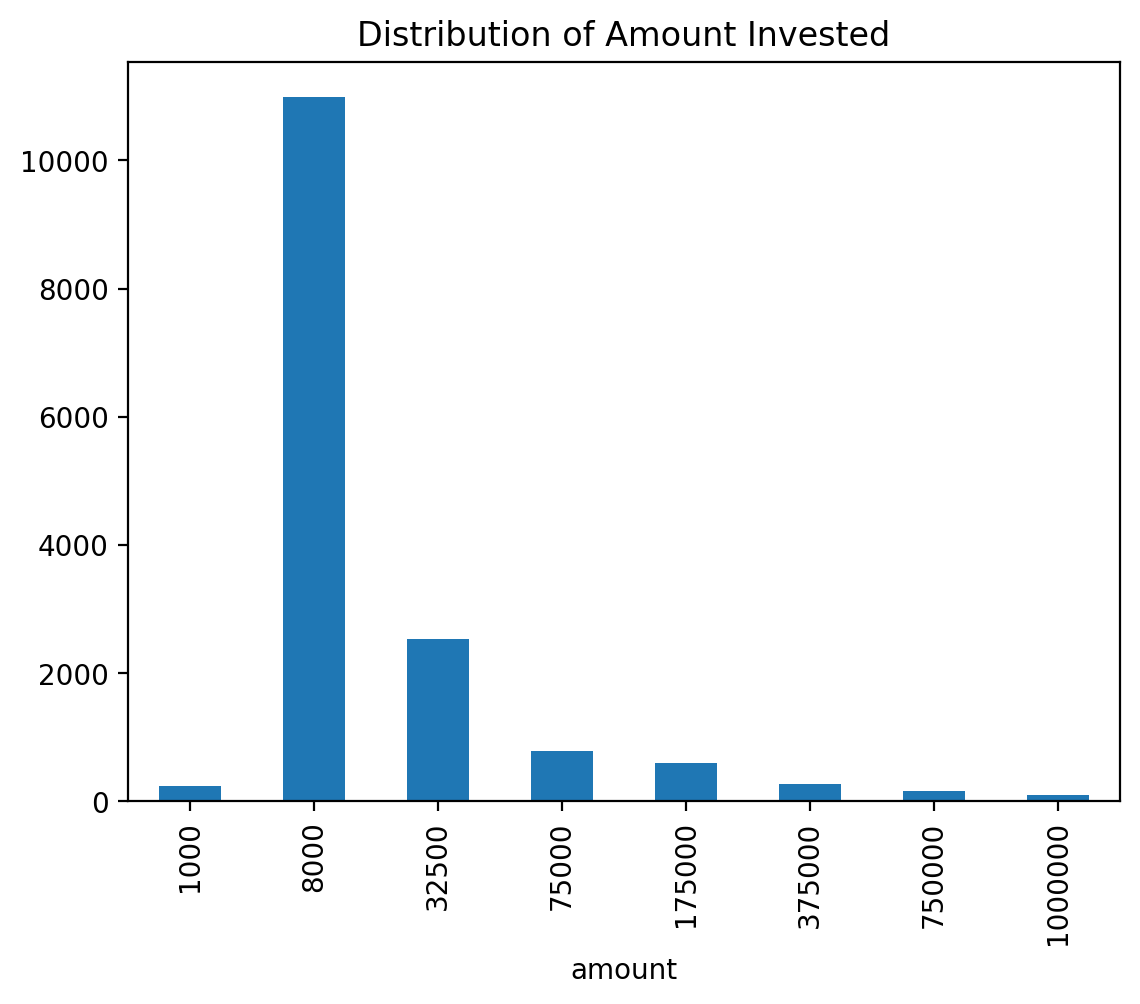

In [117]:
#Look at distribution of amount invested
stocks.groupby(['amount']).count()['representative'].plot(kind = 'bar', title = 'Distribution of Amount Invested')

We see that our investmests are skewed right, in that most of are investments are under 50k or so. This doesn't really help us visualize the distribution of the other amounts. Let's split up the amounts zoom in on the distribution of the investments that had smaller and larger amounts: 

<AxesSubplot:title={'center':'Distribution of Investments Worth more than 50k'}, xlabel='amount'>

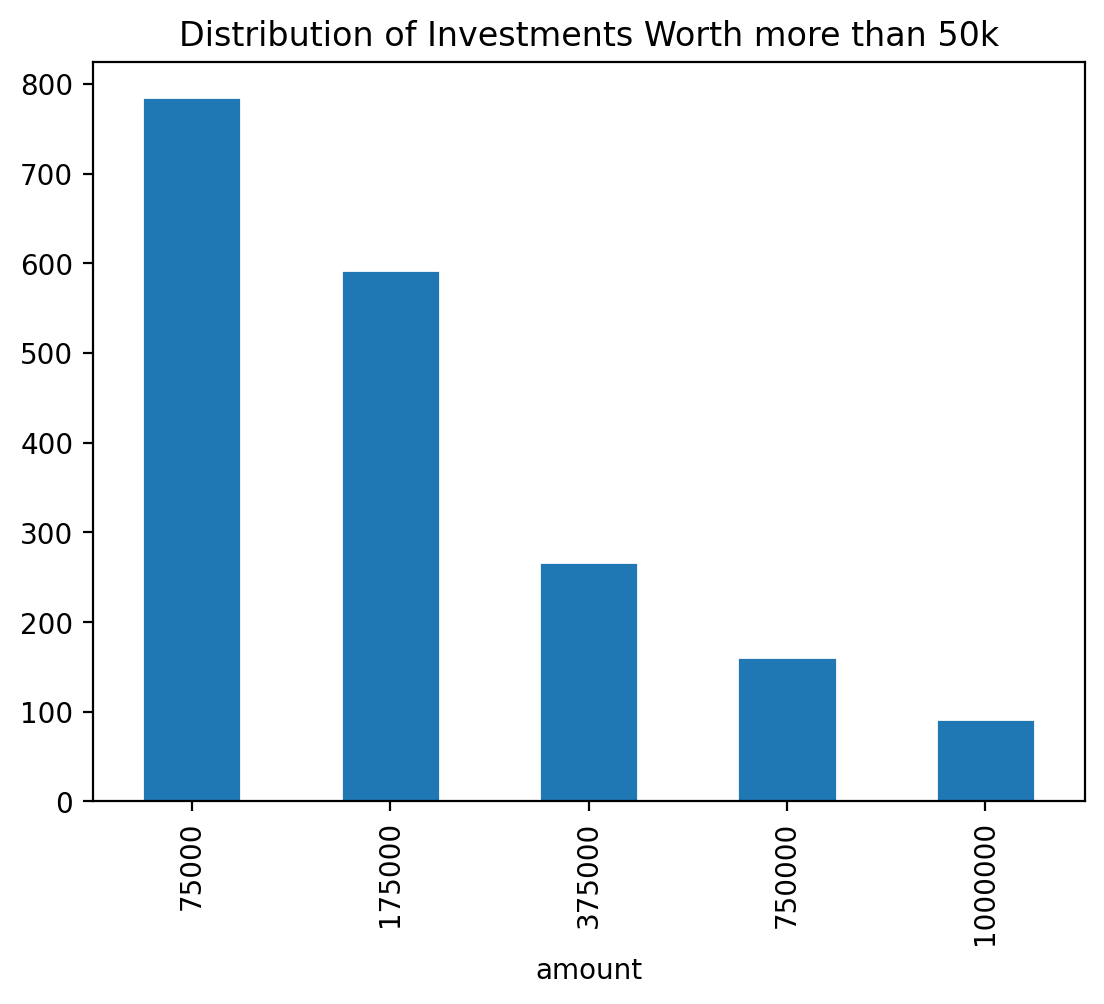

In [118]:
stocks.loc[stocks['amount'] > 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Investments Worth more than 50k', ec = 'w')

<AxesSubplot:title={'center':'Distribution of Investments Worth less than 50k'}, xlabel='amount'>

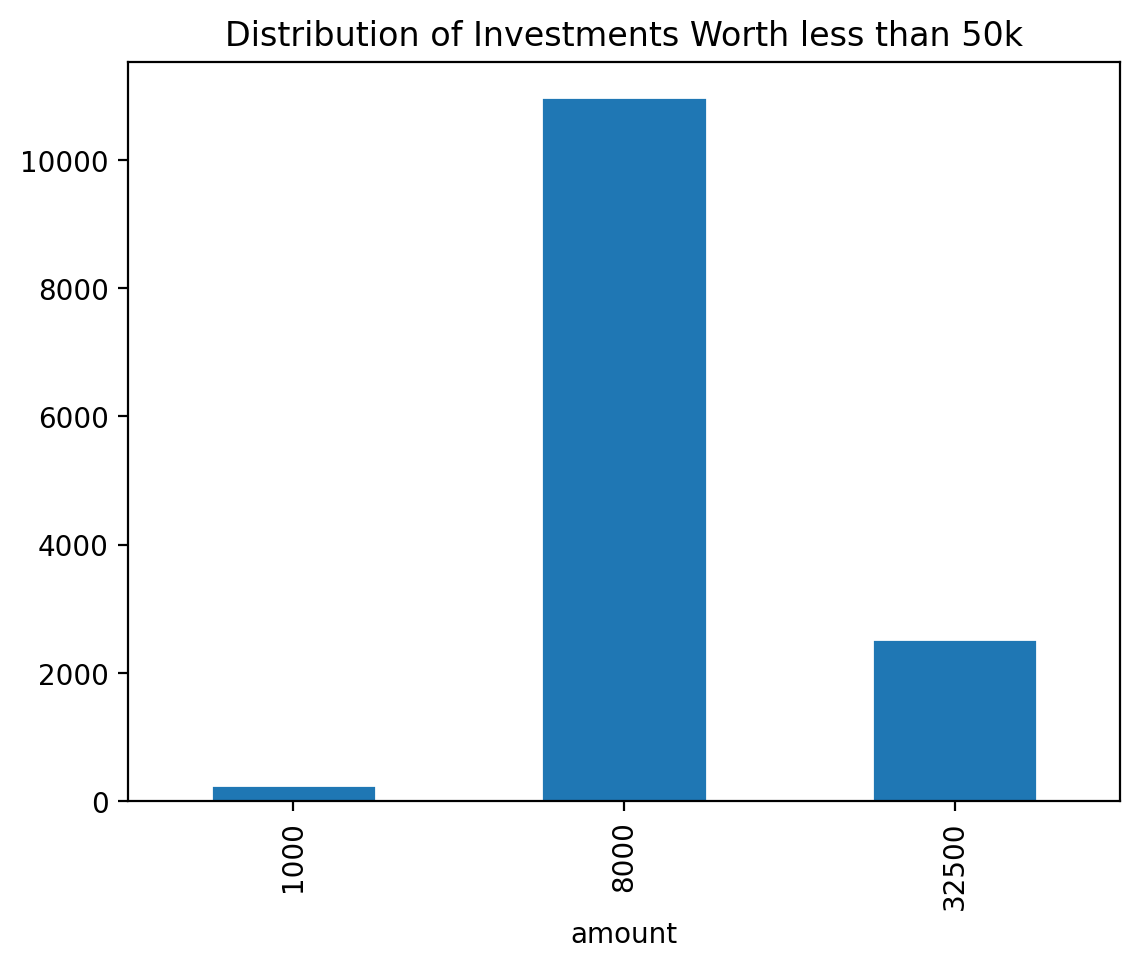

In [119]:
stocks.loc[stocks['amount'] <= 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Investments Worth less than 50k', ec = 'w')


Well, it seems like most of the investment amounts are skewed right which was what we expected anyways

In [120]:
#number of dem investments vs rep investments
party = stocks.groupby('final_party').count()
party

,ticker,amount,representative,cap_gains_over_200_usd,owner
final_party,,,,,
Democratic,8980,9741,9741,9741,5513
Republican,5091,5608,5608,5608,2714


In [121]:
#number of unique dem vs rep investors
unique_investors = stocks.groupby(['final_party', 'representative']).count()
unique_investors = unique_investors.reset_index()
unique_investors = unique_investors.groupby('final_party').count()
unique_investors

,representative,ticker,amount,cap_gains_over_200_usd,owner
final_party,,,,,
Democratic,73,73,73,73,73
Republican,80,80,80,80,80


Intersting, it seems like there are more Republicans who invest in general, but each Democrat make wayyy more transactions that each Republican

In [122]:
#how much does each MOC from each party invest
stocks.groupby('final_party').mean()
#looks like republicans invest more on average and also being more profitable in general


,amount,cap_gains_over_200_usd
final_party,,
Democratic,35982.086028,0.043527
Republican,50319.989301,0.088445


Finally, let's look at the distribution of how much each MOC from each party invests. (Again, we'll be looking at the distribution of each party as a whole, as well as for when we split the amount invested above 50k and below 50k)

<AxesSubplot:title={'center':'Distribution of Democrat Investments'}, xlabel='amount'>

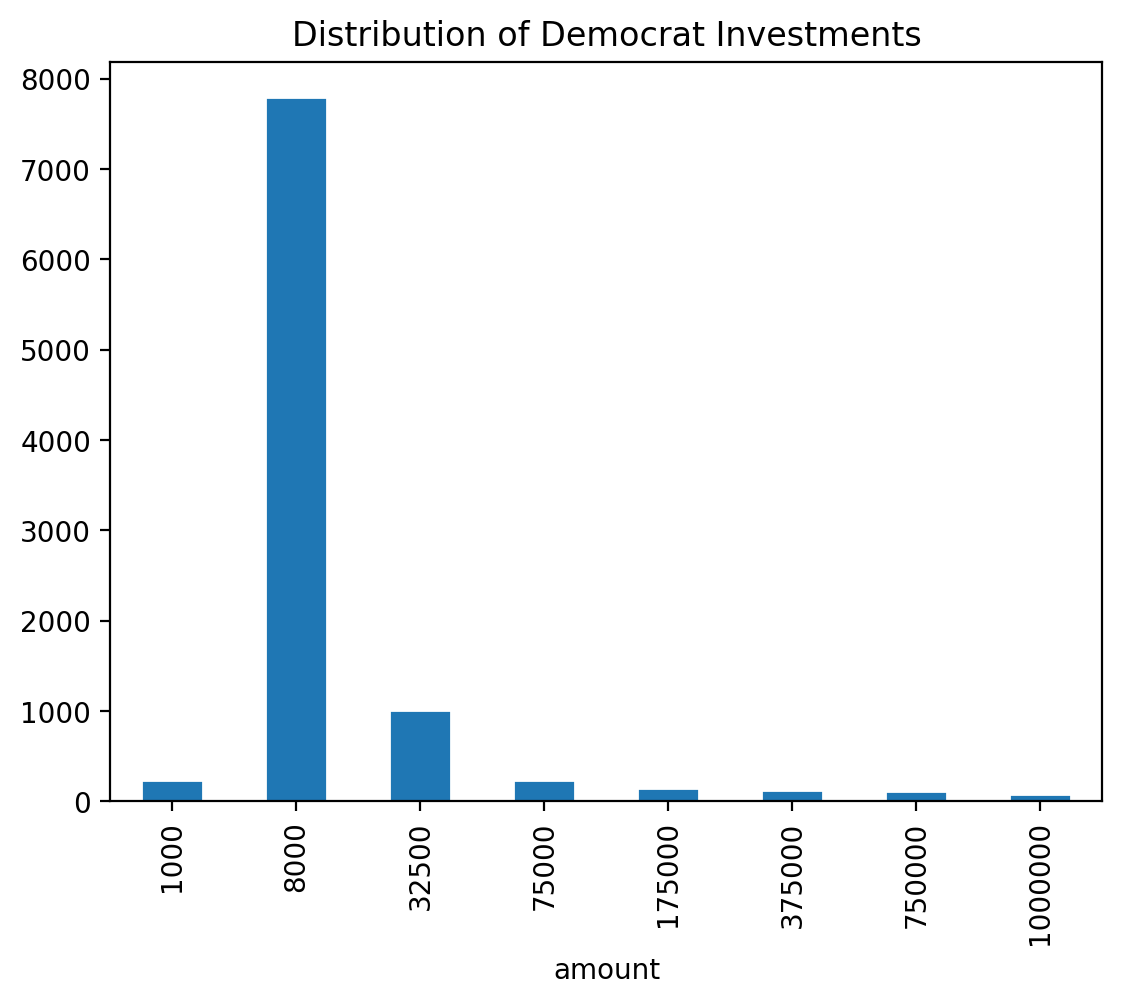

In [123]:
dems = stocks.loc[stocks['final_party'] == 'Democratic']
reps = stocks.loc[stocks['final_party'] == 'Republican']
dems.groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Democrat Investments', ec = 'w')


<AxesSubplot:title={'center':'Distribution of Republican Investments'}, xlabel='amount'>

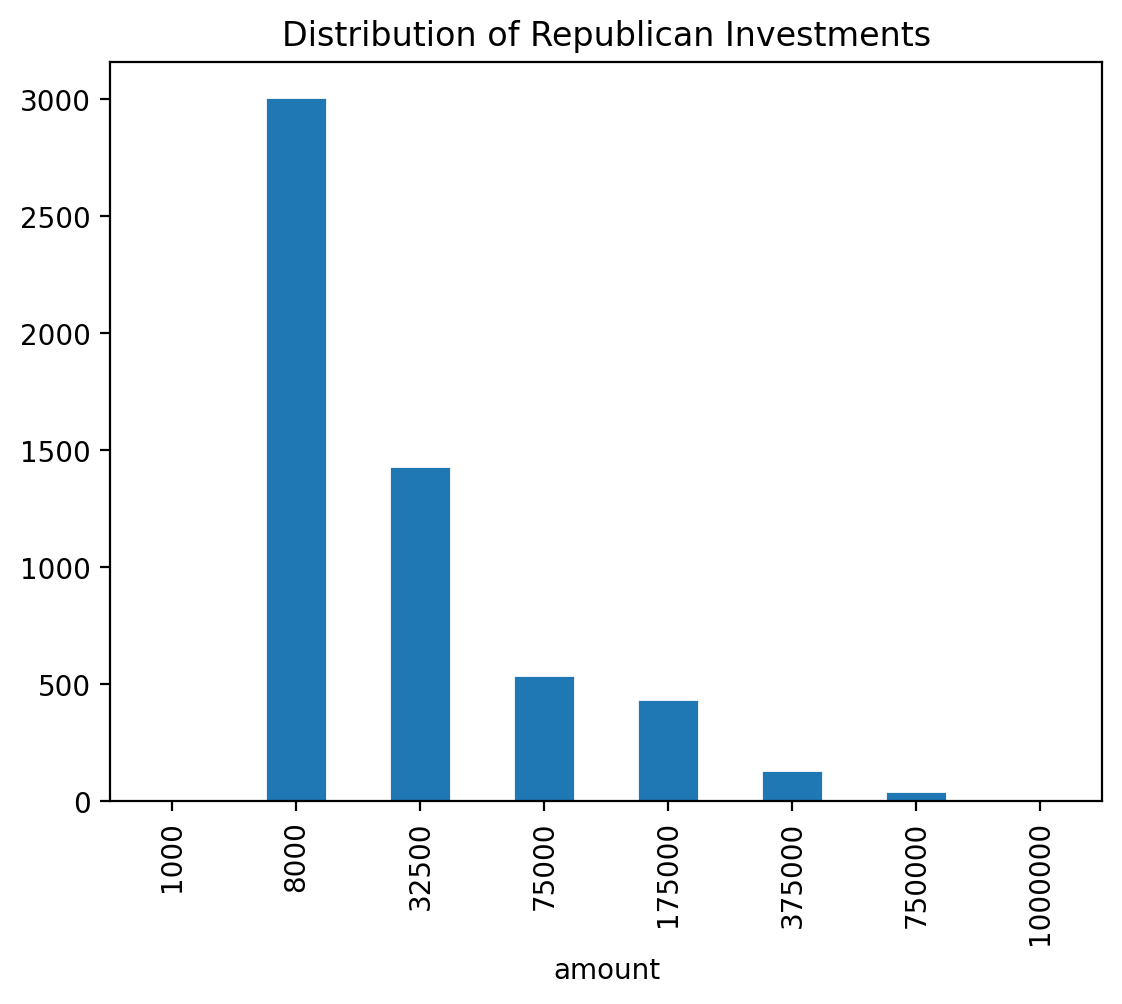

In [124]:
reps.groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Republican Investments', ec = 'w')


<AxesSubplot:title={'center':'Distribution of Democrat Investments Worth less than 50k'}, xlabel='amount'>

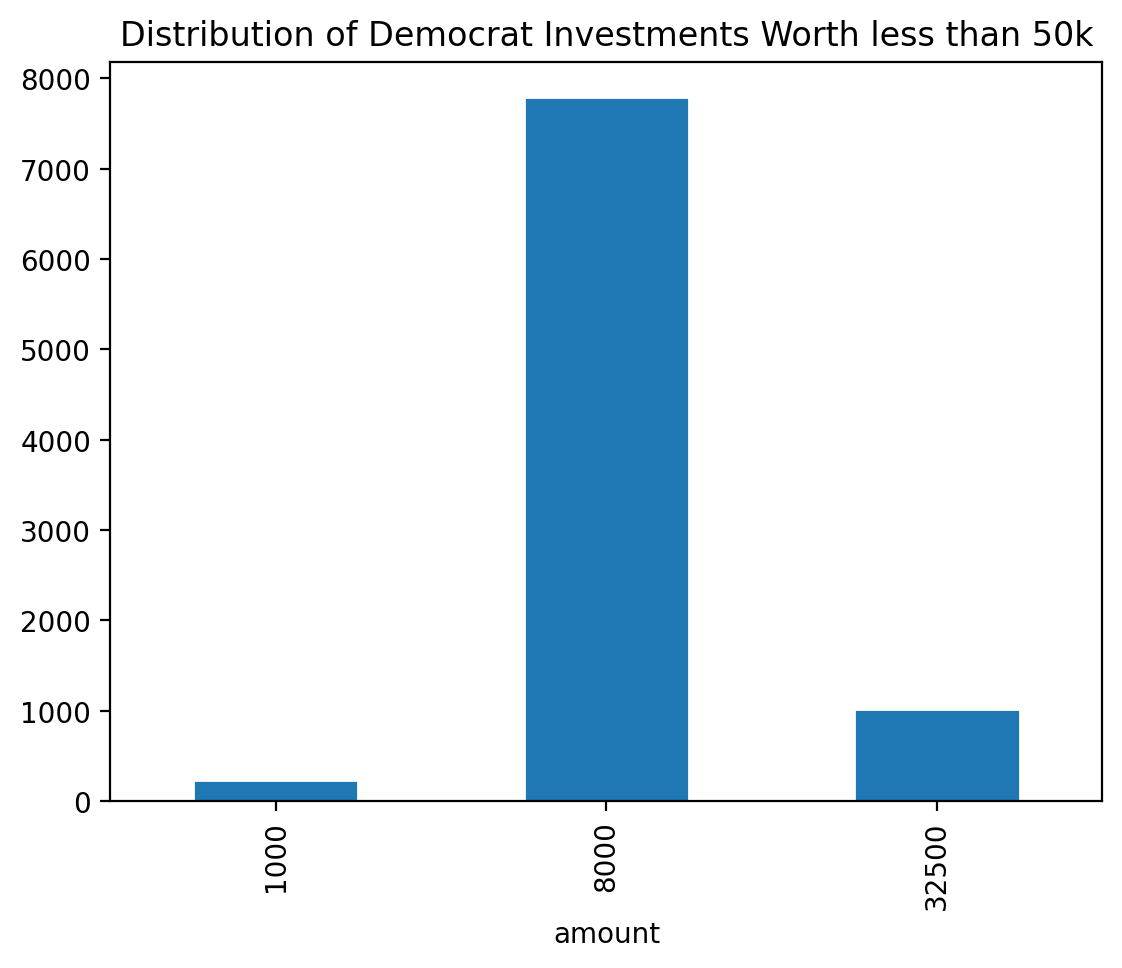

In [125]:
dems.loc[dems['amount'] <= 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Democrat Investments Worth less than 50k', ec = 'w')


<AxesSubplot:title={'center':'Distribution of Democrat Investments Worth more than 50k'}, xlabel='amount'>

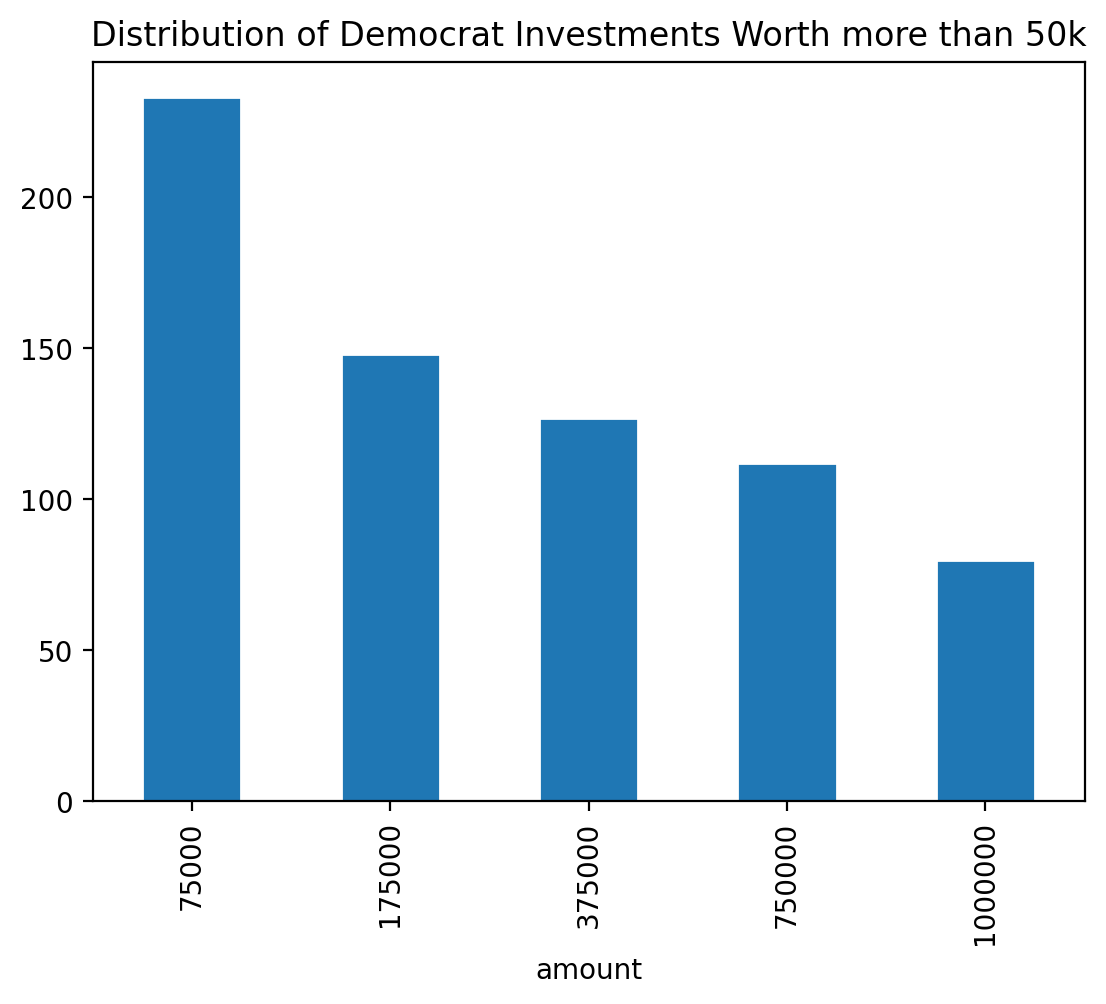

In [126]:
dems.loc[dems['amount'] > 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Democrat Investments Worth more than 50k', ec = 'w')


<AxesSubplot:title={'center':'Distribution of Republican Investments Worth less than 50k'}, xlabel='amount'>

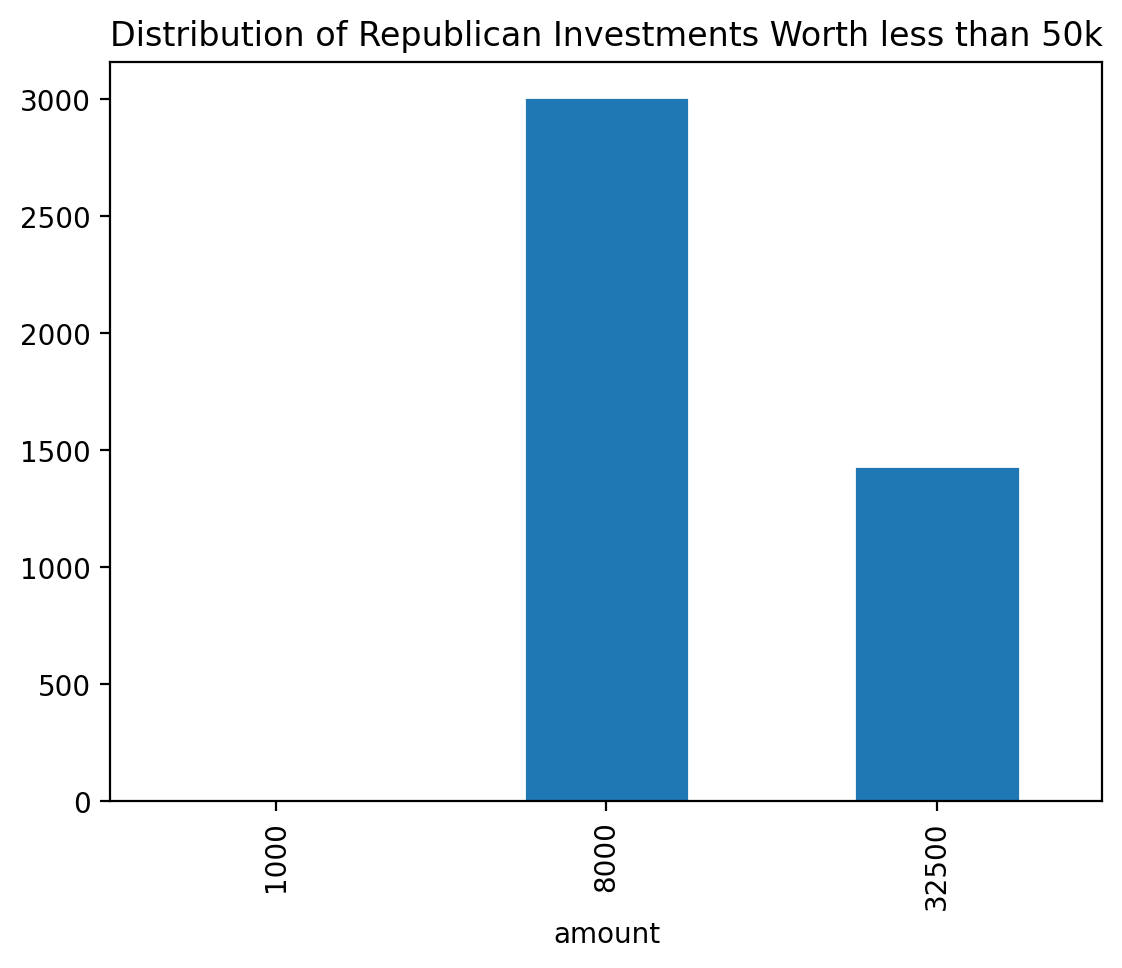

In [127]:
reps.loc[reps['amount'] <= 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Republican Investments Worth less than 50k', ec = 'w')


<AxesSubplot:title={'center':'Distribution of Republican Investments Worth more than 50k'}, xlabel='amount'>

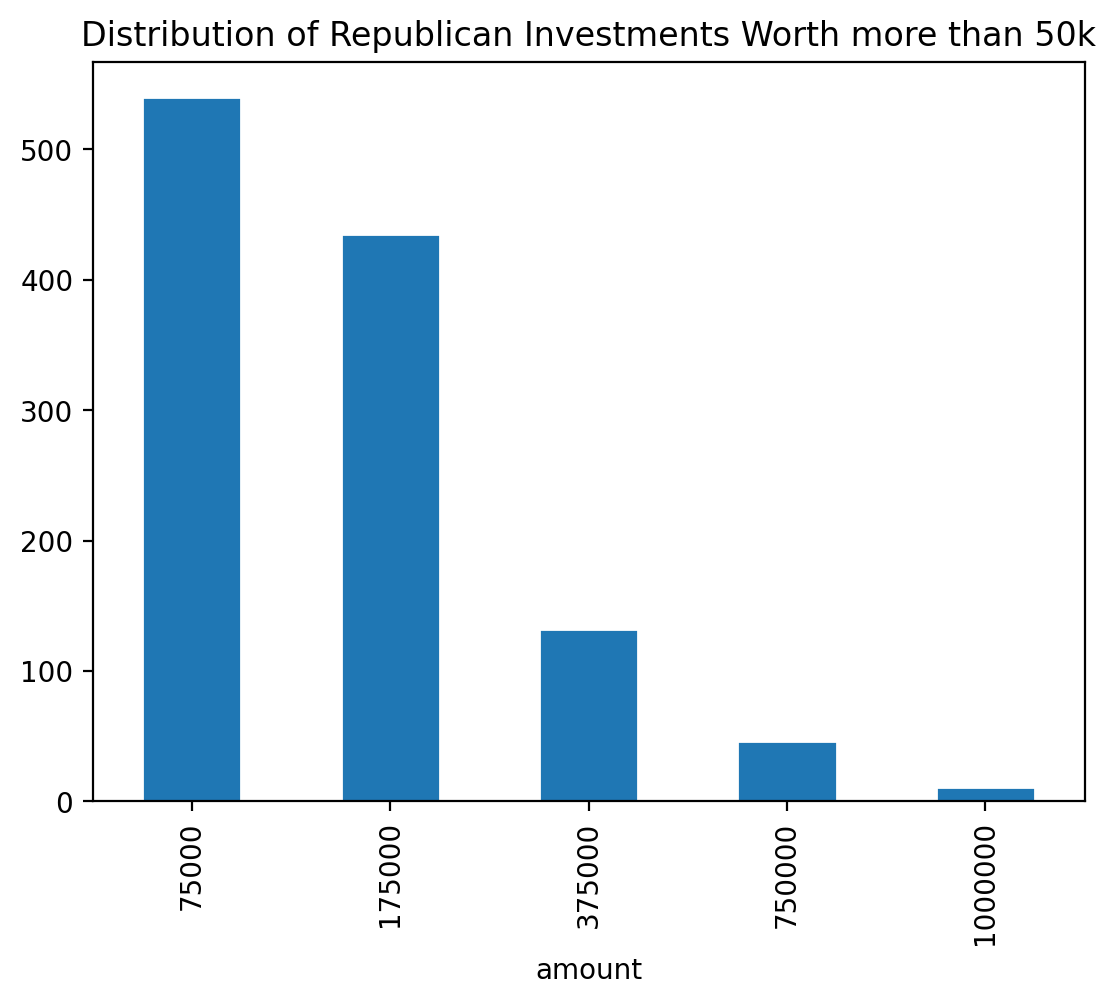

In [128]:
reps.loc[reps['amount'] > 50000].groupby(['amount'])['representative'].count().plot(kind = 'bar', title = 'Distribution of Republican Investments Worth more than 50k', ec = 'w')


Looks like most investments are in the 1k - 50k range and the investment amount is skewed right in general for both parties.

### Assessment of Missingness

Let's address the missigness of the ticker column in relation to other columns.

Luckily for us, it seems that the amount and cap_gains_over_200_usd columns aren't missing any values as seen below:

In [129]:
print(stocks.count())
print(stocks.groupby('amount').count())
print(stocks.groupby('cap_gains_over_200_usd').count())

ticker                    14370
amount                    15657
representative            15657
cap_gains_over_200_usd    15657
final_party               15349
owner                      8334
dtype: int64
         ticker  representative  cap_gains_over_200_usd  final_party  owner
amount                                                                     
1000        242             242                     242          241    232
8000      10640           10983                   10983        10800   5700
32500      2182            2534                    2534         2444   1335
75000       580             785                     785          773    401
175000      417             593                     593          583    299
375000      170             267                     267          259    165
750000       84             161                     161          158    118
1000000      55              92                      92           91     84
                        ticker  amo

Ok with that information at the back of our mind, let's start our missigness analysis by seeing the relationship of the missigness of ticker against amount. Note that when we evaluate missigness, our null hypothesis is that missing data and not missing data was drawn from the same distribution in relation with column we are comparing it to.

In [130]:
#using a tvd + permutation test (we can interpret each amount as almost a 'category' to do a tvd on)
stocks1 = stocks.copy()
missing = stocks1.loc[stocks1['ticker'].isnull()].groupby('amount')['representative'].count()/len(stocks1.loc[stocks1['ticker'].isnull()])
filled = stocks1.loc[stocks1['ticker'] == stocks1['ticker']].groupby('amount')['representative'].count()/len(stocks1.loc[stocks1['ticker'] == stocks1['ticker']])
diff = missing - filled

#calculate observed test statistic
obs = np.sum(np.abs(missing-filled).fillna(0)) / 2
tests = []

#sample test statistics via permutation test
for i in range(1000):
    stocks1['amount']  = np.random.permutation(stocks1['amount'])
    missing = stocks1.loc[stocks1['ticker'].isnull()].groupby('amount')['representative'].count()/len(stocks1.loc[stocks1['ticker'].isnull()])
    filled = stocks1.loc[stocks1['ticker'] == stocks1['ticker']].groupby('amount')['representative'].count()/len(stocks1.loc[stocks1['ticker'] == stocks1['ticker']])
    tests += [np.sum(np.abs(missing-filled).fillna(0))]

p_value = np.sum(tests >= obs) / 1000
print(p_value)


0.0


Yikes, we got a p-value of 0. This tells us that the missigness of ticker largely depends on the amount of the investment. Which makes sense since larger investments, would be considered more high profile and thus have a higher level a secrecy to them (though this is just a speculative reason). Thus the missigness of ticker is NMAR. (ticker might also be MAR since investments with private firms may be more hesitent to release investment information, however, the bottom line is that ticker has some sort of dependency on amount).

Next let's analyze the missigness of ticker against final_party.

In [131]:
#using a tvd + permutation test
stocks1 = stocks.copy()
missing = stocks1.loc[stocks1['ticker'].isnull()].groupby('final_party')['amount'].count()/len(stocks1.loc[stocks1['ticker'].isnull()])
filled = stocks1.loc[stocks1['ticker'] == stocks1['ticker']].groupby('final_party')['amount'].count()/len(stocks1.loc[stocks1['ticker'] == stocks1['ticker']])
diff = missing - filled

#calculate observed test statistic
obs = np.sum(np.abs(missing-filled).fillna(0)) / 2
tests = []

#sample test statistics via permutation test
for i in range(1000):
    stocks1['final_party']  = np.random.permutation(stocks1['final_party'])
    missing = stocks1.loc[stocks1['ticker'].isnull()].groupby('final_party')['amount'].count()/len(stocks1.loc[stocks1['ticker'].isnull()])
    filled = stocks1.loc[stocks1['ticker'] == stocks1['ticker']].groupby('final_party')['amount'].count()/len(stocks1.loc[stocks1['ticker'] == stocks1['ticker']])
    tests += [np.sum(np.abs(missing-filled).fillna(0))]

p_value = np.sum(tests >= obs) / 1000
print(p_value)

0.137


With a p-value of approximately 0.15, we could pretty safely say that ticker has almost no dependency on amount if at all. And this makes a lot of sense since what people invest in from a financial standpoint will have minimal relevance to ones political views (for instance, from a financial beneficiary standpoint, we could all agree that investing in Amazon in 2013 is a good decision whether you're a Democrat or Republican). This tells us that the missigness mechanism of ticker has no dependency on the political party of the MOC.

To summarize, the missigness of ticker is most likely NMAR since it largely depends on the amount invested, while it has low or no dependency on the party of the MOC. In terms of our question, we have to keep this at the back of my mind because we're not sure how the missigness of potential big tech tickers will present itself in the amount invested, although it should most likely be fine since we're mainly focused on comparing the parties of MOC and amount invested; and the big tech ticker is more of an intermediate step in our process.

### Hypothesis Test

Let's first consider our first question in the form of a null and alternate hypothesis.

Null Hypothesis: There is no difference in the distribution of amount spent per transaction between MOC of differing parties (ie. the amount spent per transaction between each party is drawn form the same distribtution)

Alternate Hypothesis: There is a statistically significant different in the distribution of amount spent per transaction between MOC of differing parties

We're going to use a rather tight significance level of 0.01 (this is because we have a lot of randomness in the amount our data and don't actually have the exact values of the transactions) and we're going to use TVD testing to test the difference in our distributions of our amounts. This is because our amounts are already put in predetermined bins since the data collected doesn't contain accurate amounts for each transaction, rather, each transaction is assigned a range for the amount spent on that particular transaction. We're going to use a permutation test to see each group of interest came form the same distribution according to our null hypothesis.

In [132]:
#we need to start by getting all the tech transaction through their tickers
tech_tickers = ['FB', 'AAPL', 'GOOGL', 'GOOG', 'AMZN', 'NFLX', 'TSLA', 'MSFT', 'TSM', 'TCEHY', 'ASML', 'BABA']
tech_stocks = stocks.loc[stocks['ticker'].isin(tech_tickers)]
#split by parties
dem = tech_stocks.loc[tech_stocks['final_party'] == 'Democratic']
rep = tech_stocks.loc[tech_stocks['final_party'] == 'Republican']
#groupby amount for distribution
dem = dem.groupby('amount').count()
rep = rep.groupby('amount').count()

#calculate distribution as a proportions
dem = dem['representative'] / dem['representative'].sum()
rep = rep['representative'] / rep['representative'].sum()
#observed value using TVD
obs = (np.abs(rep - dem).sum()) / 2
obs

#permutation test
tests = []
for i in range(1000):
    tech_stocks['amount'] = np.random.permutation(tech_stocks['amount'])
    dem = tech_stocks.loc[tech_stocks['final_party'] == 'Democratic']
    rep = tech_stocks.loc[tech_stocks['final_party'] == 'Republican']
    dem = dem.groupby('amount').count()
    rep = rep.groupby('amount').count()
    dem = dem['representative'] / dem['representative'].sum()
    rep = rep['representative'] / rep['representative'].sum()
    test = (np.abs(rep - dem).sum()) / 2
    tests += [test]

p_value = (tests >= obs).sum() / 1000
print(p_value)

C:\Users\jacki\AppData\Local\Temp\ipykernel_15772\3811335724.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_stocks['amount'] = np.random.permutation(tech_stocks['amount'])


0.034


With a p-value of around 0.03-0.04, we fail to reject the null, meaning that there isn't enough statistical evidence for a difference in the amount invested between republican MOC and democrat MOC. We'll attempt to validate or invalidate this conclusion in the section below.

### Conclusion/Shorcomings

While our hypothesis points to the fact that Republicans and Democrats don't have difference tendencies in the amount that they invest in big tech companies, there are actually a lot of shortcoming with this study that might undermine the validity of this study. Unfortunately, a lot of these shortcomings were out of our control which we attempt to address below:

First of all, we weren't able to get the exact amount of each transaction and we had to estimate by taking the average of the bins. The data that we worked with only gave us a range of the amount spent on each transaction, and the range of each amount was actually quite large. Thus there was a lot of randomness in the actual amount spent on each investment compared to the reported amount that was entirely out of our control.

Second, the data itself was not very complete. The data only contained information of transactions between the years 2020-2021, and contained information of only 73 unique Democrats and 80 unique Republicans. Even within just one 'iteration' of the House, there are 435 seats. So as we can see, the data we collected was actually quite a small sample that is most likely not representative of the full.

Finally, there are some valid questions on whether the limited data we collected was valid or not. At the top of our notebook, it can be inferred that MOC self-report their investment activites, so there may be a lot of bias in the data was actually collected. For instance, MOC would most likely choose to report non-suspicious investment transactions, so high profile investments (such as maybe a large investment for a private firm), may not be reported. Clearly, these biases that can easily arise from a self-report system can largely bias our data in unwanted ways.

To repeat this experiment in a more fool-proof way, it would be ideal if we could collect our data in a way that fixes many of the problems above. For example, perhaps we would request participants to report an exact amount for their transaction followed by a reciept as proof of their investment. We would also attempt to collect data on a larger subset of MOC, preferably more than 153 out of the 435 MOC (because in this day and age it wouldn't be surprising that every single MOC has invested their money at one point or another). The last concern is much harder to address due to ethical concerns. The most we could ensure is perhaps have the participants sign some sort of an agreement, but even then there are still potential problems concerning ethics. Either way, it is clear that there were a lot of holes in this experiment that could definitely be improved upon; and unfortunately, this also means that we aren't entirely certain on the validity of our result.